# This notebook will use the two-stage framework by Khosla et al. 2020 to compare the following contrastive loss functions for the first stage:

## Supervised contrastive loss functions
- Max margin contrastive loss (Hadsell et al. 2006) 
    + Euclidean distance
    + tfa.losses.contrastive_loss
- Multiclass N-pair loss (Sohn 2016) 
    + inner product distance
    + tfa.losses.npairs_loss
- Supervised NT-Xent (the normalized temperature-scaled cross entropy loss) (equation 4 in Khosla et al. 2020)
    + inner product distance

## Other params
### Distances:
- inner product 
- Euclidean

### Normalize projections


In [8]:
!git clone https://github.com/Obsinaan/contrastive_loss.git

fatal: destination path 'contrastive_loss' already exists and is not an empty directory.


In [9]:
%cd /content/contrastive_loss

/content/contrastive_loss


In [10]:
!pip install tensorflow-addons

In [11]:
!git clone https://github.com/Obsinaan/contrastive_loss.git

Cloning into 'contrastive_loss'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 78 (delta 39), reused 38 (delta 12), pack-reused 0
Unpacking objects: 100% (78/78), done.


In [12]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
!git clone

fatal: You must specify a repository to clone.

usage: git clone [<options>] [--] <repo> [<dir>]

    -v, --verbose         be more verbose
    -q, --quiet           be more quiet
    --progress            force progress reporting
    -n, --no-checkout     don't create a checkout
    --bare                create a bare repository
    --mirror              create a mirror repository (implies bare)
    -l, --local           to clone from a local repository
    --no-hardlinks        don't use local hardlinks, always copy
    -s, --shared          setup as shared repository
    --recurse-submodules[=<pathspec>]
                          initialize submodules in the clone
    -j, --jobs <n>        number of submodules cloned in parallel
    --template <template-directory>
                          directory from which templates will be used
    --reference <repo>    reference repository
    --reference-if-able <repo>
                          reference repository
    --dissociate          u

In [14]:
from model import *
import losses

In [15]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [16]:
# global configs
EPOCHS = 20
# DATA = 'mnist'
DATA = 'fashion_mnist'
NORMALIZE_EMBEDDING = True
# NORMALIZE_EMBEDDING = False
N_DATA_TRAIN = 60000
# BATCH_SIZE = 32
BATCH_SIZE = 1024 # batch_size for pre-training
PROJECTION_DIM = 128
# WRITE_SUMMARY = True
WRITE_SUMMARY = False

ACTIVATION = 'leaky_relu'
LR = 0.5 # learning rate for pre-training

In [17]:
!mkdir -p logs/

In [18]:
optimizer = tf.keras.optimizers.Adam(lr=LR)
optimizer2 = tf.keras.optimizers.Adam() # with default lr

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# 0. Load MNIST data

In [19]:
if DATA == 'mnist':
    mnist = tf.keras.datasets.mnist
elif DATA == 'fashion_mnist':
    mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28).astype(np.float32)
x_test = x_test.reshape(-1, 28*28).astype(np.float32)
print(x_train.shape, x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 784) (10000, 784)


In [20]:
# simulate low data regime for training
n_train = x_train.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [21]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)

train_ds2 = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# 1. Multi-class N-pairs loss

## Stage 1: train encoder with multiclass N-pair loss

In [22]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [23]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [24]:
@tf.function
# train step for the multiclass N-pair loss
def train_step_npair(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = losses.multiclass_npairs_loss(z, y)

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

In [25]:
@tf.function
def test_step_npair(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = losses.multiclass_npairs_loss(z, y)
    test_loss(t_loss)

In [26]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        train_step_npair(x, y)

    for x_te, y_te in test_ds:
        test_step_npair(x_te, y_te)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        test_loss.result()))

Epoch 1, Loss: 6.416478633880615, Test Loss: 6.330540657043457
Epoch 2, Loss: 6.317352294921875, Test Loss: 6.282474994659424
Epoch 3, Loss: 6.283586502075195, Test Loss: 6.265538692474365
Epoch 4, Loss: 6.261214256286621, Test Loss: 6.246847152709961
Epoch 5, Loss: 6.2510199546813965, Test Loss: 6.237161159515381
Epoch 6, Loss: 6.242881774902344, Test Loss: 6.227224826812744
Epoch 7, Loss: 6.2332048416137695, Test Loss: 6.218527793884277
Epoch 8, Loss: 6.223026275634766, Test Loss: 6.206620216369629
Epoch 9, Loss: 6.212923049926758, Test Loss: 6.20809268951416
Epoch 10, Loss: 6.207249641418457, Test Loss: 6.198629379272461
Epoch 11, Loss: 6.199987411499023, Test Loss: 6.193375587463379
Epoch 12, Loss: 6.200906753540039, Test Loss: 6.188506603240967
Epoch 13, Loss: 6.193171977996826, Test Loss: 6.186344146728516
Epoch 14, Loss: 6.192594528198242, Test Loss: 6.192794322967529
Epoch 15, Loss: 6.189667224884033, Test Loss: 6.183604717254639
Epoch 16, Loss: 6.188880920410156, Test Loss: 6.

In [27]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [28]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [29]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


## Check learned embedding

In [30]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
print(x_tr_proj.shape)
print(x_te_proj_pca.shape)

(60000, 256)
(10000, 2)


In [31]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
print(x_train.shape)
x_te_pca.shape

(60000, 784)


(10000, 2)

In [32]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test
# x_te_proj_df.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


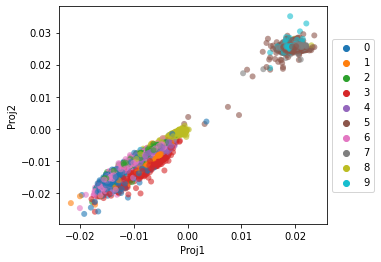

In [33]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


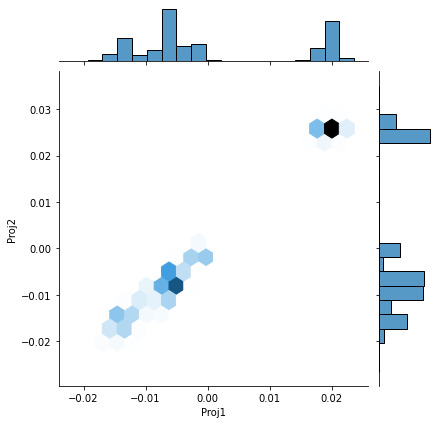

In [34]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );

In [35]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


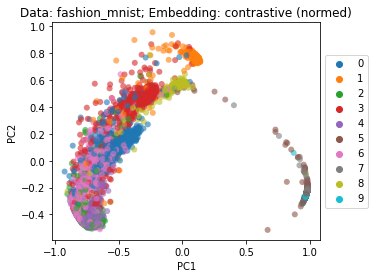

In [36]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_contrastive_embed.png' % DATA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


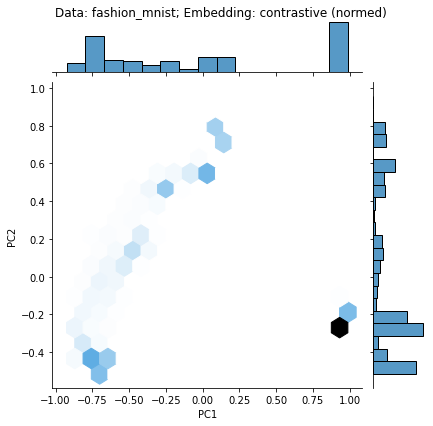

In [37]:
g = sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_contrastive_embed.png' % DATA)

In [38]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


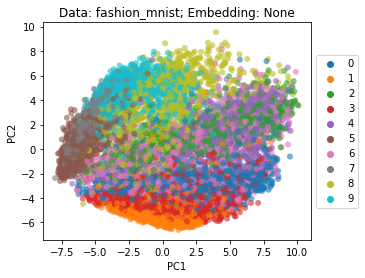

In [39]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_no_embed.png' % DATA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


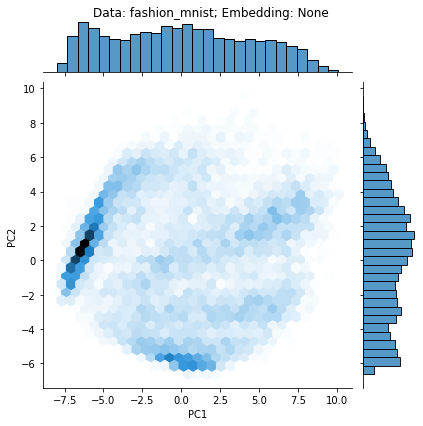

In [40]:
g = sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_no_embed.png' % DATA)

## Stage 2: freeze the learned representations and then learn a classifier on a linear layer using a softmax loss

In [41]:
softmax = SoftmaxPred()

In [42]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [43]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [44]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer2.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [45]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [46]:
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [47]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds2:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.938400149345398, Acc: 72.30332946777344, Test Loss: 0.6800576448440552, Test Acc: 75.66999816894531
Epoch 2, Loss: 0.5987748503684998, Acc: 78.6933364868164, Test Loss: 0.6089911460876465, Test Acc: 77.63999938964844
Epoch 3, Loss: 0.5523719787597656, Acc: 80.15166473388672, Test Loss: 0.5827927589416504, Test Acc: 79.2699966430664
Epoch 4, Loss: 0.5316302180290222, Acc: 80.81999969482422, Test Loss: 0.5693019032478333, Test Acc: 79.79999542236328
Epoch 5, Loss: 0.5192685127258301, Acc: 81.23833465576172, Test Loss: 0.5607699155807495, Test Acc: 79.75
Epoch 6, Loss: 0.5106937289237976, Acc: 81.48333740234375, Test Loss: 0.5532718896865845, Test Acc: 80.29000091552734
Epoch 7, Loss: 0.504088819026947, Acc: 81.68333435058594, Test Loss: 0.5474816560745239, Test Acc: 80.30999755859375
Epoch 8, Loss: 0.4987151324748993, Acc: 81.86833190917969, Test Loss: 0.5427945852279663, Test Acc: 80.38999938964844
Epoch 9, Loss: 0.49396073818206787, Acc: 82.02000427246094, Test Loss: 0

In [48]:
test_acc.result().numpy()

0.8153

# 2. Supervised NT-Xent

In [49]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING, activation=ACTIVATION)

In [50]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [51]:
@tf.function
# train step for the multiclass N-pair loss
def train_step_sup_nt_xent(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=True)
        z = projector(r, training=True)
        loss = losses.supervised_nt_xent_loss(z, y, temperature=0.1)

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))
    train_loss(loss)

In [52]:
@tf.function
def test_step_sup_nt_xent(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)
    t_loss = losses.supervised_nt_xent_loss(z, y, temperature=0.1)
    test_loss(t_loss)

In [53]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        train_step_sup_nt_xent(x, y)

    for x_te, y_te in test_ds:
        test_step_sup_nt_xent(x_te, y_te)

    template = 'Epoch {}, Loss: {}, Test Loss: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        test_loss.result()))

Epoch 1, Loss: 8.721635818481445, Test Loss: 8.548918724060059
Epoch 2, Loss: 8.494729995727539, Test Loss: 8.438340187072754
Epoch 3, Loss: 8.40494441986084, Test Loss: 8.358683586120605
Epoch 4, Loss: 8.318697929382324, Test Loss: 8.28969669342041
Epoch 5, Loss: 8.259915351867676, Test Loss: 8.244821548461914
Epoch 6, Loss: 8.213921546936035, Test Loss: 8.204512596130371
Epoch 7, Loss: 8.170430183410645, Test Loss: 8.16751480102539
Epoch 8, Loss: 8.121734619140625, Test Loss: 8.109935760498047
Epoch 9, Loss: 8.054642677307129, Test Loss: 8.055646896362305
Epoch 10, Loss: 7.983996391296387, Test Loss: 7.974228858947754
Epoch 11, Loss: 7.91446590423584, Test Loss: 7.886626243591309
Epoch 12, Loss: 7.813239574432373, Test Loss: 7.81908655166626
Epoch 13, Loss: 7.747910022735596, Test Loss: 7.791231632232666
Epoch 14, Loss: 7.707619667053223, Test Loss: 7.731269836425781
Epoch 15, Loss: 7.6665568351745605, Test Loss: 7.729531764984131
Epoch 16, Loss: 7.644881248474121, Test Loss: 7.68844

In [54]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 256])

In [55]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 256])

In [56]:
# convert tensor to np.array
x_tr_proj = x_tr_proj.numpy()
x_te_proj = x_te_proj.numpy()
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 256) (10000, 256)


## Check learned embedding

In [57]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [58]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [59]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test
# x_te_proj_df.head()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


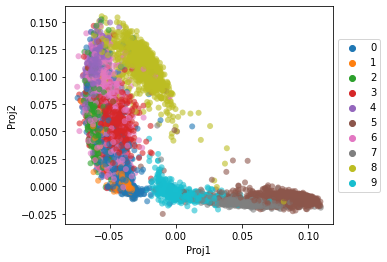

In [60]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


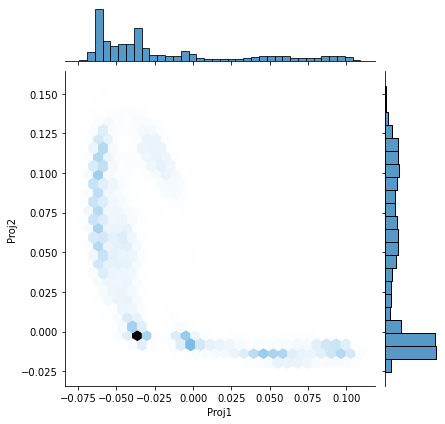

In [61]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );

In [62]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


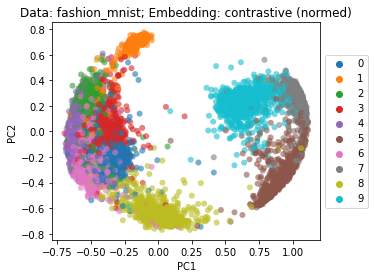

In [63]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', 
                     data=x_te_proj_pca_df,
                     palette='tab10',
                     hue='label',
                     linewidth=0,
                     alpha=0.6,
                     ax=ax
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
title = 'Data: %s; Embedding: contrastive'% DATA
if NORMALIZE_EMBEDDING:
    title = 'Data: %s; Embedding: contrastive (normed)'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_contrastive_embed.png' % DATA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


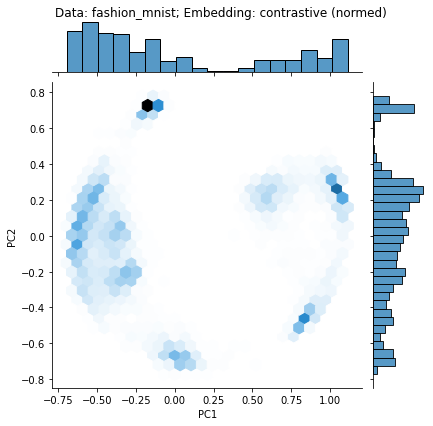

In [64]:
g = sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )
plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_contrastive_embed.png' % DATA)

In [65]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


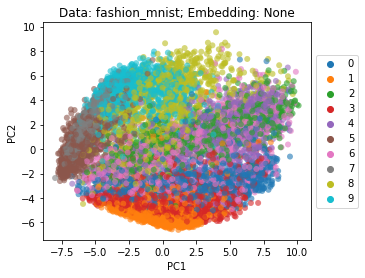

In [66]:
fig, ax = plt.subplots()
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6,
                     ax=ax
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

title = 'Data: %s; Embedding: None'% DATA
ax.set_title(title);
# fig.savefig('figs/PCA_plot_%s_no_embed.png' % DATA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


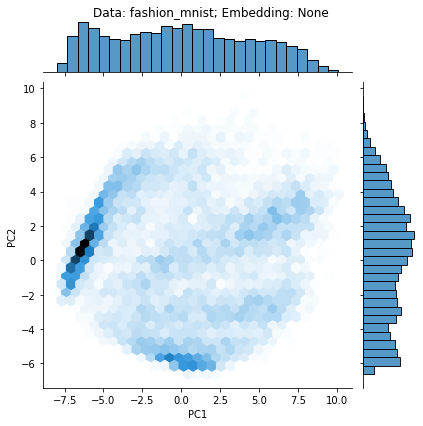

In [67]:
g = sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

plt.subplots_adjust(top=0.95)
g.fig.suptitle(title);
# g.savefig('figs/Joint_PCA_plot_%s_no_embed.png' % DATA)

## Stage 2: freeze the learned representations and then learn a classifier on a linear layer using a softmax loss

In [68]:
softmax = SoftmaxPred()

In [69]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [70]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [71]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer2.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [72]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)

    t_loss = cce_loss_obj(y, y_preds)

    test_loss(t_loss)
    test_acc(y, y_preds)

In [73]:
model_name = 'contrast_loss_model'
if not NORMALIZE_EMBEDDING:
    model_name = 'contrast_loss_model-no_norm'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [74]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds2:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1, Loss: 0.8390383720397949, Acc: 77.70000457763672, Test Loss: 0.6663993000984192, Test Acc: 80.4000015258789
Epoch 2, Loss: 0.5826181173324585, Acc: 82.6883316040039, Test Loss: 0.5754055976867676, Test Acc: 81.88999938964844
Epoch 3, Loss: 0.5168206691741943, Acc: 83.87000274658203, Test Loss: 0.5318498611450195, Test Acc: 82.79000091552734
Epoch 4, Loss: 0.48224911093711853, Acc: 84.46499633789062, Test Loss: 0.5083139538764954, Test Acc: 83.31000518798828
Epoch 5, Loss: 0.4613223373889923, Acc: 84.83999633789062, Test Loss: 0.4920634627342224, Test Acc: 83.67000579833984
Epoch 6, Loss: 0.447424054145813, Acc: 85.12667083740234, Test Loss: 0.48209619522094727, Test Acc: 83.76000213623047
Epoch 7, Loss: 0.4375200867652893, Acc: 85.30667114257812, Test Loss: 0.47428473830223083, Test Acc: 83.77000427246094
Epoch 8, Loss: 0.43013736605644226, Acc: 85.4749984741211, Test Loss: 0.46870002150535583, Test Acc: 83.80000305175781
Epoch 9, Loss: 0.4244179129600525, Acc: 85.579994201660